# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 4</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import Image
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
viviendas_caba=pd.read_csv('./Datasets/viviendas_caba.csv').copy()

pca_df=pd.read_csv('./Datasets/pca_properati_argentina_2021.csv').copy()

poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 2. Regresión

## Modelo 1: KNN

### Dataset completo:

#### Eleccion de variables regresoras

**Realizamos Encoding**

para variable property_type y barrio

In [22]:
viviendas_caba_encoded = viviendas_caba.copy()
viviendas_caba_encoded['property_type'] = LabelEncoder().fit_transform(viviendas_caba['property_type'])
viviendas_caba_encoded['barrio'] = LabelEncoder().fit_transform(viviendas_caba['barrio'])
viviendas_caba_encoded.head(2)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-09-09,2021-09-26,-34.637319,-58.361124,7,1,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,POINT (-58.361124 -34.6373187)
1,2021-09-09,2021-09-28,-34.628647,-58.361871,7,1,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,POINT (-58.3618713 -34.6286465)


In [35]:
#Heatmap correlación
viviendas_caba_encoded.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.141103,0.016952,-0.065060,-0.026360,-0.028009,0.021501,0.040684,0.165261
longitud,-0.141103,1.000000,-0.254398,-0.073198,0.009903,0.007454,-0.004242,0.047954,0.126130
barrio,0.016952,-0.254398,1.000000,0.037220,-0.017533,-0.022601,0.016797,0.000657,-0.005310
property_type,-0.065060,-0.073198,0.037220,1.000000,-0.065310,-0.072324,-0.170745,-0.198191,-0.132513
property_rooms,-0.026360,0.009903,-0.017533,-0.065310,1.000000,0.926325,0.757079,0.770356,0.523442
property_bedrooms,-0.028009,0.007454,-0.022601,-0.072324,0.926325,1.000000,0.724889,0.736133,0.483020
property_surface_total,0.021501,-0.004242,0.016797,-0.170745,0.757079,0.724889,1.000000,0.954240,0.723027
property_surface_covered,0.040684,0.047954,0.000657,-0.198191,0.770356,0.736133,0.954240,1.000000,0.776274
property_price,0.165261,0.126130,-0.005310,-0.132513,0.523442,0.483020,0.723027,0.776274,1.000000


**Variables Regresoras**

Gracias al análisis de feature importance realizado en la parte de clasificación sabemos que **latitud** (0.30), **longitud** (0.23), **property_surface_total** (0.16) y **property_surface_covered** (0.15) son las features más importantes para predecir el precio de una propiedad por lo que las seleccionamos como **variables regresoras**. 

Además vemos en la matriz de correlación que barrio y property_type no parecen tener relacion fuerte con el precio

In [23]:
#selecciono variables regresoras y a predecir
X_train_knn = viviendas_caba_train[['latitud','longitud', 'property_surface_total', 'property_surface_covered']]
X_test_knn = viviendas_caba_test[['latitud','longitud', 'property_surface_total', 'property_surface_covered']]

y_train_knn = viviendas_caba_train.property_price
y_test_knn= viviendas_caba_test.property_price

In [37]:
#Heatmap correlación
X_train_knn.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,property_surface_total,property_surface_covered
latitud,1.000000,-0.142706,0.020934,0.039337
longitud,-0.142706,1.000000,-0.003481,0.048280
property_surface_total,0.020934,-0.003481,1.000000,0.954711
property_surface_covered,0.039337,0.048280,0.954711,1.000000


#### Ingeniería de características

**Valores Atípicos**

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

**Normalizado de datos**

Decidimos usar min-max para normalizar ya que fue el que mejores resultados nos dió

In [24]:
scaler = MinMaxScaler() 
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

**Optimizamos los parámetros usando random search cross validation**

In [25]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor=KNeighborsRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_knn = RandomizedSearchCV(knn_regressor, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_knn.fit(X_train_knn, y_train_knn)
rand_knn.cv_results_['mean_test_score']

array([0.89209683, 0.87617969, 0.89281254, 0.85667565, 0.88619061])

In [26]:
#Mejores hiperparametros
print(rand_knn.best_params_)
#Mejor métrica
print(rand_knn.best_score_)

{'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
0.8928125421776774


#### Métricas sobre train

In [27]:
#Mejor estimador
best_knn_regressor = rand_knn.best_estimator_

#Predicción con mejor estimador
y_pred_train_knn = best_knn_regressor.predict(X_train_knn)

#Coef. de Determinación R2
r2_score_train = r2_score(y_train_knn, y_pred_train_knn)
print(f'Coef. de Determinación R2: {r2_score(y_train_knn, y_pred_train_knn)}')

#Coef. de Determinación R2 ajustado
n = X_train_knn.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_knn,
        y_pred  = y_pred_train_knn,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_knn,
        y_pred  = y_pred_train_knn,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9979367781753948
Coef. de Determinación R2 ajustado: 0.9979366670972056
El error (mse) de test es: 180228024.84074247
El error (rmse) de test es: 13424.903159454912


In [42]:
# Performance
performance_train = pd.DataFrame({'Valor Real': y_train_knn,
                            'Prediccion': y_pred_train_knn.round(),
                            'Error': y_train_knn - y_pred_train_knn.round()})
# View
performance_train.head()

,Valor Real,Prediccion,Error
0,167113.0,165587.0,1526.0
1,129000.0,129000.0,0.0
2,124600.0,124600.0,0.0
3,196000.0,196000.0,0.0
4,235000.0,235000.0,0.0


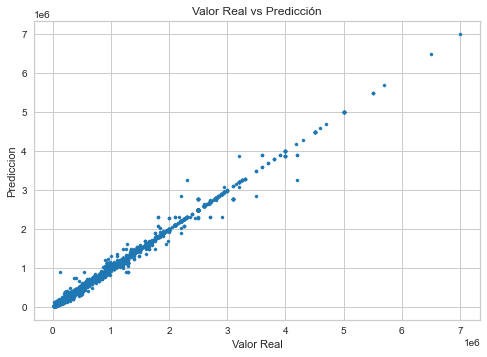

In [43]:
scatter_real_predict_train = performance_train.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test 

In [28]:
#Predicción con mejor estimador
y_pred_test_knn = best_knn_regressor.predict(X_test_knn)

#Coef. de Determinación R2
r2_score_test = r2_score(y_test_knn, y_pred_test_knn)
print(f'Coef. de Determinación R2: {r2_score_test}')

#Coef. de Determinación R2 ajustado
n = X_test_knn.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_test_knn,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_test_knn,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.8815285389821065
Coef. de Determinación R2 ajustado: 0.8815030214631753
El error (mse) de test es: 11079641835.626738
El error (rmse) de test es: 105259.87761548432


In [45]:
# Performance
performance_test = pd.DataFrame({'Valor Real': y_test_knn,
                            'Prediccion': y_pred_test_knn.round(),
                            'Error': y_test_knn - y_pred_test_knn.round()})
# View
performance_test.head()

,Valor Real,Prediccion,Error
0,140000.0,128856.0,11144.0
1,69900.0,80500.0,-10600.0
2,75900.0,63286.0,12614.0
3,315000.0,225454.0,89546.0
4,79000.0,78500.0,500.0


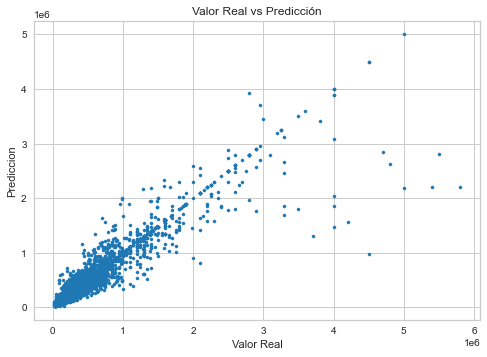

In [46]:
scatter_real_predict_test = performance_test.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Dataset con reducción de dimensionalidad:

#### Eleccion de variables regresoras

**Variables Regresoras**

Gracias al análisis de feature importance realizado en la parte de clasificación sabemos que para obtener el mejor r2 tenemos que elegir a las 4 componentes principales como variables regresoras

In [47]:
#selecciono variables regresoras y a predecir
X_knn_pca = pca_df[['cp_1','cp_2','cp_3', 'cp_4']]
y_knn_pca = pca_df.property_price

#Separacion Train/test  (80/20)
X_train_knn_pca, X_test_knn_pca, y_train_knn_pca, y_test_knn_pca = train_test_split(X_knn_pca, y_knn_pca, test_size= 0.2, random_state=12)

#### Ingeniería de características

**Valores Atípicos**

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

**Normalizado de datos**

Decidimos usar min-max para normalizar ya que fue el que mejores resultados nos dió

In [48]:
scaler = MinMaxScaler() 
X_train_knn_pca = scaler.fit_transform(X_train_knn_pca)
X_test_knn_pca = scaler.transform(X_test_knn_pca)

**Optimizamos los parámetros usando Random Search Cross Validation**

In [49]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor_pca=KNeighborsRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_knn_pca = RandomizedSearchCV(knn_regressor_pca, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_knn_pca.fit(X_train_knn_pca, y_train_knn_pca)
rand_knn_pca.cv_results_['mean_test_score']

array([0.76064808, 0.70659373, 0.76337521, 0.74928197, 0.74587282])

In [50]:
#Mejores hiperparametros
print(rand_knn_pca.best_params_)
#Mejor métrica
print(rand_knn_pca.best_score_)

{'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
0.7633752072686366


#### Métricas sobre train

In [51]:
#Mejor estimador
best_knn_regressor_pca = rand_knn_pca.best_estimator_

#Predicción con mejor estimador
y_pred_train_knn_pca = best_knn_regressor_pca.predict(X_train_knn_pca)

#Coef. de Determinación R2
r2_score_train_knn_pca = r2_score(y_train_knn_pca, y_pred_train_knn_pca)
print(f'Coef. de Determinación R2: {r2_score_train_knn_pca}')

#Coef. de Determinación R2 ajustado
n = X_train_knn_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train_knn_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_knn_pca,
        y_pred  = y_pred_train_knn_pca,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_knn_pca,
        y_pred  = y_pred_train_knn_pca,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9688657344036952
Coef. de Determinación R2 ajustado: 0.9688640581753332
El error (mse) de test es: 2737640806.2529674
El error (rmse) de test es: 52322.469420440844


In [52]:
# Performance
performance_train_knn_pca = pd.DataFrame({'Valor Real': y_train_knn_pca,
                            'Prediccion': y_pred_train_knn_pca.round(),
                            'Error': y_train_knn_pca - y_pred_train_knn_pca.round()})
# View
performance_train_knn_pca.head()

,Valor Real,Prediccion,Error
59523,89000.0,89000.0,0.0
76456,140000.0,140000.0,0.0
26920,290000.0,239500.0,50500.0
27840,89000.0,89000.0,0.0
20164,650000.0,707500.0,-57500.0


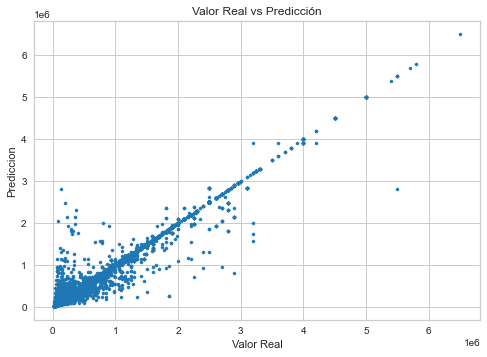

In [53]:
scatter_real_predict_train = performance_train_knn_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test 

In [54]:
#Predicción con mejor estimador
y_pred_test_knn_pca = best_knn_regressor_pca.predict(X_test_knn_pca)

#Coef. de Determinación R2
r2_score_test_knn_pca = r2_score(y_test_knn_pca, y_pred_test_knn_pca)
print(f'Coef. de Determinación R2: {r2_score_test_knn_pca}')

#Coef. de Determinación R2 ajustado
n = X_test_knn_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_knn_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_knn_pca,
        y_pred  = y_pred_test_knn_pca,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_knn_pca,
        y_pred  = y_pred_test_knn_pca,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.7883237188516572
Coef. de Determinación R2 ajustado: 0.7882781259851129
El error (mse) de test es: 19309058295.20586
El error (rmse) de test es: 138957.03758790292


In [55]:
# Performance
performance_test_knn_pca = pd.DataFrame({'Valor Real': y_test_knn_pca,
                            'Prediccion': y_pred_test_knn_pca.round(),
                            'Error': y_test_knn_pca - y_pred_test_knn_pca.round()})
# View
performance_test_knn_pca.head()

,Valor Real,Prediccion,Error
53374,85000.0,139318.0,-54318.0
897,289000.0,189682.0,99318.0
41973,235000.0,200330.0,34670.0
20322,92000.0,147184.0,-55184.0
84681,129000.0,193995.0,-64995.0


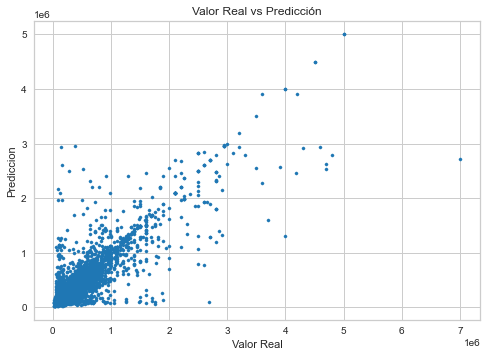

In [56]:
scatter_real_predict_test = performance_test_knn_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Conclusiones KNN


Utilizamos 5 folds porque no obtuvimos mejoras al utilizar mayor cantidad.

Observamos que los resultados sobre el dataset original fueron mejores (en cuanto a métricas) comparados con los del dataset con reducción pca.



+ Coeficiente de determinación 𝑹^𝟐: me dice cuanto explica la variabilidad del problema (0 explica poco, 1 explica mucho).
+ Coeficiente de determinación 𝑹^𝟐 ajustado: similar a 𝑹^𝟐 solo que penaliza x la cantidad de variables incluidas en el modelo.
+ MSE:(Error Cuadrático Medio (Mean Squared Error)): Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
+ RMSE: es la raíz cuadrada de MSE, es mas fácil de interpretar ya que estará en las mismas unidades (dólares) que las del problema (a menor RMSE mejor)


## Modelo 2: XGBoost

### Dataset completo:

**Variables Regresoras**

Por el análisis de feature importance realizado en la parte de clasificación sabemos que **latitud** (0.30), **longitud** (0.23), **property_surface_total** (0.16), **property_surface_covered** (0.15) y **property_rooms** (0.02) son las features más importantes para predecir el precio de una propiedad por lo que las seleccionamos como **variables regresoras**. 

In [11]:
#selecciono variables regresoras y a predecir
x_train_xgb = viviendas_caba_train[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'property_rooms']]
x_test_xgb = viviendas_caba_test[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'property_rooms']]

y_train_xgb = viviendas_caba_train.property_price
y_test_xgb = viviendas_caba_test.property_price

In [12]:
scaler = MinMaxScaler() 
x_train_xgb = scaler.fit_transform(x_train_xgb)
x_test_xgb = scaler.transform(x_test_xgb)

In [13]:
import xgboost as xgb
#Grilla de Parámetros
params_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

#Clasificador KNN
xgb_regressor = xgb.XGBRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_xgb = RandomizedSearchCV(xgb_regressor, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_xgb.fit(x_train_xgb, y_train_xgb)
rand_xgb.cv_results_['mean_test_score']

array([0.83776683, 0.86855054, 0.89735585, 0.8614709 , 0.91063937])

In [14]:
best_xgb_regressor = rand_xgb.best_estimator_
best_xgb_regressor

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Métricas sobre train

In [15]:
#Predicción con mejor estimador
y_pred_train_xgb = best_xgb_regressor.predict(x_train_xgb)

#Coef. de Determinación R2
r2_score_train_xgb = r2_score(y_train_xgb, y_pred_train_xgb)
print(f'Coef. de Determinación R2: {r2_score_train_xgb}')

#Coef. de Determinación R2 ajustado
n = x_train_xgb.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_xgb,
        y_pred  = y_pred_train_xgb,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_xgb,
        y_pred  = y_pred_train_xgb,
        squared = False
       )

print(f"El error (rmse) de train es: {rmse}")

Coef. de Determinación R2: 0.9853714785296712
Coef. de Determinación R2 ajustado: 0.9853706909703038
El error (mse) de train es: 1277841044.2814214
El error (rmse) de train es: 35746.902583040974


In [16]:
# Performance
performance_train_xgb = pd.DataFrame({'Valor Real': y_train_xgb,
                            'Prediccion': y_pred_train_xgb.round(),
                            'Error': y_train_xgb - y_pred_train_xgb.round()})
# View
performance_train_xgb.head()

,Valor Real,Prediccion,Error
0,167113.0,134552.0,32561.0
1,129000.0,128032.0,968.0
2,124600.0,130931.0,-6331.0
3,196000.0,165463.0,30537.0
4,235000.0,175644.0,59356.0


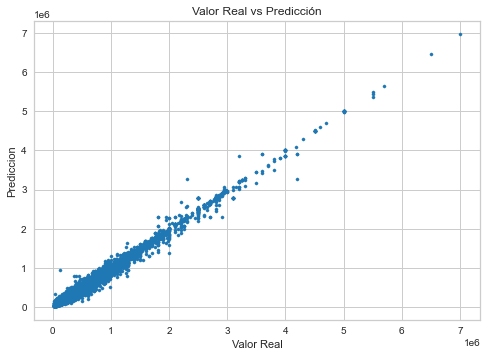

In [17]:
scatter_real_predict_train_xgb = performance_train_xgb.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test

In [18]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_regressor.predict(x_test_xgb)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_xgb, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_xgb.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_xgb,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_xgb,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9019645365048344
Coef. de Determinación R2 ajustado: 0.9019434206869473
El error (mse) de test es: 9168434434.619144
El error (rmse) de test es: 95751.94219763453


In [20]:
# Performance
performance_test_xgb = pd.DataFrame({'Valor Real': y_test_xgb,
                            'Prediccion': y_pred_test_xgb.round(),
                            'Error': y_test_xgb - y_pred_test_xgb.round()})
# View
performance_test_xgb.head()

,Valor Real,Prediccion,Error
0,140000.0,109444.0,30556.0
1,69900.0,84489.0,-14589.0
2,75900.0,69397.0,6503.0
3,315000.0,193416.0,121584.0
4,79000.0,74877.0,4123.0


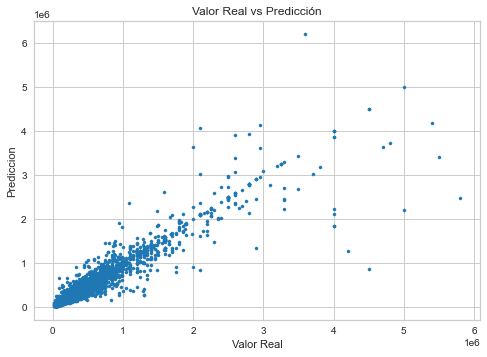

In [21]:
scatter_real_predict_test__xgb = performance_test_xgb.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Dataset con reducción de dimensionalidad:

**Variables Regresoras**

Gracias al análisis de feature importance realizado en la parte de clasificación sabemos que para obtener el mejor r2 tenemos que elegir a las 4 componentes principales como variables regresoras

In [67]:
#selecciono variables regresoras y a predecir
X_xgb_pca = pca_df[['cp_1','cp_2','cp_3', 'cp_4']]
y_xgb_pca = pca_df.property_price

#Separacion Train/test  (80/20)
x_train_xgb_pca, x_test_xgb_pca, y_train_xgb_pca, y_test_xgb_pca = train_test_split(X_xgb_pca, y_xgb_pca, test_size= 0.2, random_state=12)

In [68]:
scaler = MinMaxScaler() 
x_train_xgb_pca = scaler.fit_transform(x_train_xgb_pca)
x_test_xgb_pca = scaler.transform(x_test_xgb_pca)

In [69]:
import xgboost as xgb
#Grilla de Parámetros
params_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

#Clasificador KNN
xgb_regressor_pca = xgb.XGBRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_xgb_pca = RandomizedSearchCV(xgb_regressor_pca, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_xgb_pca.fit(x_train_xgb_pca, y_train_xgb_pca)
rand_xgb_pca.cv_results_['mean_test_score']

array([0.73126314, 0.75653379, 0.76498285, 0.74515482, 0.76388702])

In [70]:
best_xgb_regressor_pca = rand_xgb_pca.best_estimator_
best_xgb_regressor_pca

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Métricas sobre train

In [71]:
#Predicción con mejor estimador
y_pred_train_xgb_pca = best_xgb_regressor_pca.predict(x_train_xgb_pca)

#Coef. de Determinación R2
r2_score_train_xgb_pca = r2_score(y_train_xgb_pca, y_pred_train_xgb_pca)
print(f'Coef. de Determinación R2: {r2_score_train_xgb_pca}')

#Coef. de Determinación R2 ajustado
n = x_train_xgb_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train_xgb_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_xgb_pca,
        y_pred  = y_pred_train_xgb_pca,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_xgb_pca,
        y_pred  = y_pred_train_xgb_pca,
        squared = False
       )

print(f"El error (rmse) de train es: {rmse}")

Coef. de Determinación R2: 0.8636292656816953
Coef. de Determinación R2 ajustado: 0.8636219236587428
El error (mse) de train es: 11991099834.800097
El error (rmse) de train es: 109503.88045544366


In [72]:
# Performance
performance_train_xgb_pca = pd.DataFrame({'Valor Real': y_train_xgb_pca,
                            'Prediccion': y_pred_train_xgb_pca.round(),
                            'Error': y_train_xgb_pca - y_pred_train_xgb_pca.round()})
# View
performance_train_xgb_pca.head()

,Valor Real,Prediccion,Error
59523,89000.0,143508.0,-54508.0
76456,140000.0,130431.0,9569.0
26920,290000.0,198923.0,91077.0
27840,89000.0,98242.0,-9242.0
20164,650000.0,819091.0,-169091.0


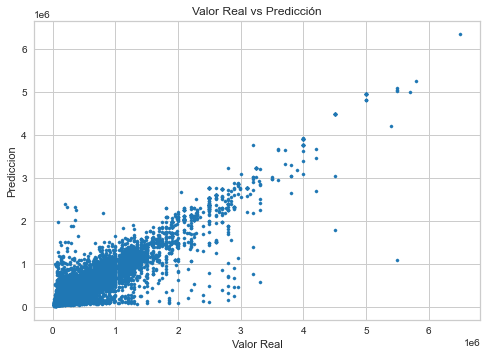

In [73]:
scatter_real_predict_train_xgb_pca = performance_train_xgb_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test

In [74]:
#Predicción con mejor estimador
y_pred_test_xgb_pca = best_xgb_regressor_pca.predict(x_test_xgb_pca)

#Coef. de Determinación R2
r2_score_test_xgb_pca = r2_score(y_test_xgb_pca, y_pred_test_xgb_pca)
print(f'Coef. de Determinación R2: {r2_score_test_xgb_pca}')

#Coef. de Determinación R2 ajustado
n = x_test_xgb_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_xgb_pca,
        y_pred  = y_pred_test_xgb_pca,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_xgb_pca,
        y_pred  = y_pred_test_xgb_pca,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.785095662990897
Coef. de Determinación R2 ajustado: 0.7850493748347376
El error (mse) de test es: 19603520756.741264
El error (rmse) de test es: 140012.57356659533


In [75]:
# Performance
performance_test_xgb_pca = pd.DataFrame({'Valor Real': y_test_xgb_pca,
                            'Prediccion': y_pred_test_xgb_pca.round(),
                            'Error': y_test_xgb_pca - y_pred_test_xgb_pca.round()})
# View
performance_test_xgb_pca.head()

,Valor Real,Prediccion,Error
53374,85000.0,101839.0,-16839.0
897,289000.0,179931.0,109069.0
41973,235000.0,196831.0,38169.0
20322,92000.0,120060.0,-28060.0
84681,129000.0,186490.0,-57490.0


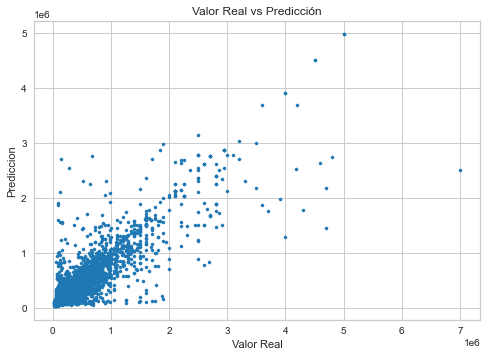

In [76]:
scatter_real_predict_test__xgb_pca = performance_test_xgb_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Conclusiones XGBoost


Utilizamos 5 folds porque no obtuvimos mejoras al utilizar una mayor cantidad.

Observamos que los resultados obtenidos son similares a los de KNN, aunque todas las métricas son levemente mejores.

La volvemos a observar que predice mejor el dataset sin reduccion de dimensionalidad

## Modelo 3: GradientBoostingRegressor

### Dataset completo:

**Variables Regresoras**

Por el análisis de feature importance realizado en la parte de clasificación sabemos que **latitud** (0.30), **longitud** (0.23), **property_surface_total** (0.16) y **property_surface_covered** (0.15) son las features más importantes para predecir el precio de una propiedad por lo que las seleccionamos como **variables regresoras**. 

In [3]:
#selecciono variables regresoras y a predecir
x_train_GBR = viviendas_caba_train[['latitud', 'longitud','property_surface_total', 'property_surface_covered']]
x_test_GBR = viviendas_caba_test[['latitud', 'longitud','property_surface_total', 'property_surface_covered']]


y_train_GBR = viviendas_caba_train.property_price
y_test_GBR = viviendas_caba_test.property_price

In [4]:
scaler = MinMaxScaler() 
x_train_GBR = scaler.fit_transform(x_train_GBR)
x_test_GBR = scaler.transform(x_test_GBR)

In [5]:
num_estimators = [500,1000]
learn_rates = [0.02, 0.05]
max_depths = [4, 10]
min_samples_leaf = [5,10]
min_samples_split = [5,10]

param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

random_search =RandomizedSearchCV(GradientBoostingRegressor(loss='huber'), param_grid, random_state=1, n_iter=5, cv=5, verbose=0, n_jobs=-1)

random_search.fit(x_train_GBR, y_train_GBR)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(loss='huber'),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.02, 0.05],
                                        'max_depth': [4, 10],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [500, 1000]},
                   random_state=1)

In [6]:
#random_search = GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1000)
#random_search.fit(x_train_GBR, y_train_GBR)


random_search.best_estimator_: 

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=10,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=1000)

In [7]:
#y_pred_test_GBR = random_search.predict(x_test_GBR)
#y_pred_train_GBR = random_search.predict(x_train_GBR)

#### Métricas sobre train

In [18]:
#Mejor estimador
best_GBR_regressor = random_search.best_estimator_

#Predicción con mejor estimador
y_pred_train_GBR = best_GBR_regressor.predict(x_train_GBR)

#Coef. de Determinación R2
r2_score_train_GBR = r2_score(y_train_GBR, y_pred_train_GBR)
print(f'Coef. de Determinación R2: {r2_score_train_GBR}')

#Coef. de Determinación R2 ajustado
n = x_train_GBR.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train_GBR)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_GBR,
        y_pred  = y_pred_train_GBR,
        squared = True
       )

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_GBR,
        y_pred  = y_pred_train_GBR,
        squared = False
       )

print(f"El error (rmse) de train es: {rmse}")

Coef. de Determinación R2: 0.9616944358067002
Coef. de Determinación R2 ajustado: 0.9616923735404647
El error (mse) de train es: 3346094972.744725
El error (rmse) de train es: 57845.44037990138


In [19]:
# Performance
performance_train_GBR = pd.DataFrame({'Valor Real': y_train_GBR,
                            'Prediccion': y_pred_train_GBR.round(),
                            'Error': y_train_GBR - y_pred_train_GBR.round()})
# View
performance_train_GBR.head()

,Valor Real,Prediccion,Error
0,167113.0,139447.0,27666.0
1,129000.0,124489.0,4511.0
2,124600.0,134043.0,-9443.0
3,196000.0,164235.0,31765.0
4,235000.0,200099.0,34901.0


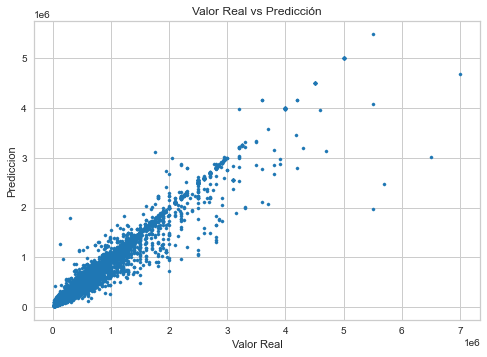

In [20]:
scatter_real_predict_train_GBR = performance_train_GBR.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test

In [21]:
#Predicción con mejor estimador
y_pred_test_GBR = best_GBR_regressor.predict(x_test_GBR)

#Coef. de Determinación R2
r2_score_test = r2_score(y_test_GBR, y_pred_test_GBR)
print(f'Coef. de Determinación R2: {r2_score_test}')

#Coef. de Determinación R2 ajustado
n = x_test_GBR.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_GBR,
        y_pred  = y_pred_test_GBR,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_GBR,
        y_pred  = y_pred_test_GBR,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9084317779115889
Coef. de Determinación R2 ajustado: 0.9084120550701504
El error (mse) de test es: 8563607602.606391
El error (rmse) de test es: 92539.76227874367


In [22]:
# Performance
performance_test_GBR = pd.DataFrame({'Valor Real': y_test_GBR,
                            'Prediccion': y_pred_test_GBR.round(),
                            'Error': y_test_GBR - y_pred_test_GBR.round()})
# View
performance_test_GBR.head()

,Valor Real,Prediccion,Error
0,140000.0,109117.0,30883.0
1,69900.0,79620.0,-9720.0
2,75900.0,64462.0,11438.0
3,315000.0,186197.0,128803.0
4,79000.0,75916.0,3084.0


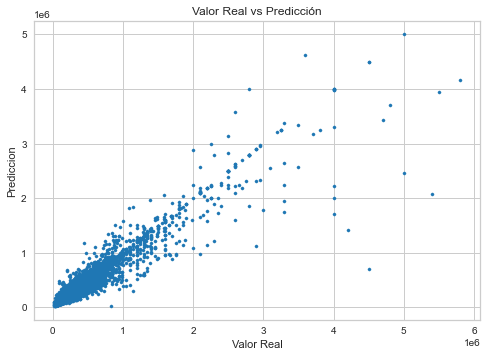

In [23]:
scatter_real_predict_test_GBR = performance_test_GBR.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Dataset con reducción de dimensionalidad: